In [1]:
using JuMP
import Ipopt
using StaticArrays, LinearAlgebra
using Plots
using Symbolics: Symbolics, @variables, scalarize
using Latexify
using BlockArrays: Block, BlockVector, mortar, blocksizes
using Ipopt
using SparseArrays
using CSV
using DataFrames
using Tables

In [6]:
function uni_dyna(x,u)
    return [x[1]+dt*u[1]*cos(x[3]), x[2]+dt*u[1]*sin(x[3]), x[3]+dt*u[2]]
end

function circleShape(h, k, r); gr()
    theta = LinRange(0, 2*pi, 500)
    h.+ r*sin.(theta), k.+ r*cos.(theta)
end

N = 100
n_x = 6
n_u = 4
state_dimension = 3
control_dimension = 2
horizon = N
tf = 10.
dt = tf/(N)
u1_b = 0.15
u2_b = 0.75

xo = @SVector [10.0,0.0]
xo2 = @SVector [11.0, 3.0]
ro = 4.0
ro2 = 3.0
ra = 3.0

# Q = 50.0*Diagonal(@SVector ones(6))
# Qf = 10000.0*Diagonal(@SVector ones(6))
# R = 1.0e0*Diagonal(@SVector ones(4))

Q = Diagonal(@SVector [50, 10, 5, 50, 10, 5, 5, 5, 2, 2])*0.6 # This is reference tracking and control cost
Qf = Diagonal(@SVector [50, 10, 5, 50, 10, 5, 5, 5, 2, 2])*50
R = Diagonal(@SVector [10, 10, 5, 5])*0.8

noise_level = 1.0

full_traj = []

num_sim = 10

for sim in 1:num_sim

    x0 = [0,0,0,20,0,pi] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]
    xf = [20,0.0,0,0,0,pi] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]

    # xf2 = @SVector [20,-2,0,0,-2,pi]

    X_ref = hcat(collect(LinRange(x0[1],xf[1],N+1)), 
            collect(LinRange(x0[2],xf[2],N+1)),
            collect(LinRange(x0[3],xf[3],N+1)),
            collect(LinRange(x0[4],xf[4],N+1)), 
            collect(LinRange(x0[5],xf[5],N+1)),
            collect(LinRange(x0[6],xf[6],N+1)), zeros(N+1),zeros(N+1), zeros(N+1),zeros(N+1))

    problem_size = N*(n_x+n_u)

    model = Model(Ipopt.Optimizer)

    @variable(model, x11[1:N+1])
    @variable(model, x12[1:N+1])
    @variable(model, x13[1:N+1])
    @variable(model, x21[1:N+1])
    @variable(model, x22[1:N+1])
    @variable(model, x23[1:N+1])

    @variable(model, 0<=u11[1:N+1] , start = 0)
    @variable(model, u12[1:N+1], start = 0);
    @variable(model, 0<=u21[1:N+1], start = 0)
    @variable(model, u22[1:N+1], start = 0);

    @variable(model, -u1_b <= du11[1:N+1] <= u1_b, start = 0)
    @variable(model, -u2_b <= du12[1:N+1] <= u2_b, start = 0);
    @variable(model, -u1_b <= du21[1:N+1] <= u1_b, start = 0)
    @variable(model, -u2_b <= du22[1:N+1] <= u2_b, start = 0);

    fix(x11[1],x0[1],force=true)
    fix(x12[1],x0[2],force=true)
    fix(x13[1],x0[3],force=true)
    fix(x21[1],x0[4],force=true)
    fix(x22[1],x0[5],force=true)
    fix(x23[1],x0[6],force=true)

    fix(u11[N+1],0.0,force=true)
    fix(u12[N+1],0.0,force=true)
    fix(u21[N+1],0.0,force=true)
    fix(u22[N+1],0.0,force=true)

    fix(du11[N+1],0.0,force=true)
    fix(du12[N+1],0.0,force=true)
    fix(du21[N+1],0.0,force=true)
    fix(du22[N+1],0.0,force=true)

    X_full = vcat(x11',x12',x13',x21',x22',x23',u11',u21',u12',u22')
    U_full = vcat(du11',du21',du12',du22')

    @objective(model, Min, tr((X_full'[1:N,:] - X_ref[1:N,:])*Q*(X_full[:,1:N] - X_ref'[:,1:N])) + tr(U_full'*R*U_full) + (X_full'[1+N,:] - X_ref[1+N,:])'*Qf*(X_full[:,1+N] - X_ref'[:,1+N]))

    @constraint(model, [t in 1:N], uni_dyna([x11[t],x12[t],x13[t]],[u11[t],u12[t]]) == [x11[t+1],x12[t+1],x13[t+1]]);
    @constraint(model, [t in 1:N], uni_dyna([x21[t],x22[t],x23[t]],[u21[t],u22[t]]) == [x21[t+1],x22[t+1],x23[t+1]]);
    @constraint(model, [t in 1:N], [u21[t]+du21[t+1],u22[t]+du22[t+1]] == [u21[t+1],u22[t+1]]);
    @constraint(model, [t in 1:N], [u11[t]+du11[t+1],u12[t]+du12[t+1]] == [u11[t+1],u12[t+1]]);
    @constraint(model, [t in 1:N+1], (x21[t] - x11[t])^2 + (x22[t] - x12[t])^2 - ra^2 >= 0);
    @constraint(model, [t in 1:N+1], (xo[1] - x11[t])^2 + (xo[2] - x12[t])^2 - ro^2 >= 0);
    @constraint(model, [t in 1:N+1], (xo[1] - x21[t])^2 + (xo[2] - x22[t])^2 - ro^2 >= 0);
    @constraint(model, [t in 1:N+1], (xo2[1] - x11[t])^2 + (xo2[2] - x12[t])^2 - ro2^2 >= 0);
    @constraint(model, [t in 1:N+1], (xo2[1] - x21[t])^2 + (xo2[2] - x22[t])^2 - ro2^2 >= 0);

    for i in 1:N+1
        set_start_value(x11[i],X_ref[i,1]+ 0.1*(2*rand()-1))
        set_start_value(x12[i],X_ref[i,2]+ 0.1*(2*rand()-1))
        set_start_value(x13[i],X_ref[i,3]+ 0.1*(2*rand()-1))
        set_start_value(x21[i],X_ref[i,4]+ 0.1*(2*rand()-1))
        set_start_value(x22[i],X_ref[i,5]+ 0.1*(2*rand()-1))
        set_start_value(x23[i],X_ref[i,6]+ 0.1*(2*rand()-1))

        set_start_value(u11[i],X_ref[i,7])
        set_start_value(u12[i],X_ref[i,8])
        set_start_value(u21[i],X_ref[i,9])
        set_start_value(u22[i],X_ref[i,10])

        set_start_value(du11[i],0.0)
        set_start_value(du12[i],0.0)
        set_start_value(du21[i],0.0)
        set_start_value(du22[i],0.0)
        
    end

    optimize!(model)

    @assert is_solved_and_feasible(model)

    X1 = hcat(value.(x11),value.(x12),value.(x13))
    X2 = hcat(value.(x21),value.(x22),value.(x23))

    traj = hcat(value.(u11),value.(u12),value.(u21),value.(u22),
                value.(x11),value.(x12),value.(x13), 
                value.(x21),value.(x22),value.(x23))

    if sim == 1
        full_traj = traj[1:100,:]
        Plots.plot(X1[:,1],X1[:,2],color="blue",label="Agent 1")
        Plots.plot!(X2[:,1],X2[:,2],color="orange",label="Agent 2")
        Plots.plot!(circleShape(xo[1], xo[2], ro), seriestype = [:shape, ], lw=0.5, c = :gray, linecolor = :white, legend = false, fillalpha = 0.2, aspect_ratio = 1)
        Plots.plot!(circleShape(xo2[1], xo2[2], ro2), seriestype = [:shape, ], lw=0.5, c = :gray, linecolor = :white, legend = false, fillalpha = 0.2, aspect_ratio = 1)
    else
        full_traj = vcat(full_traj,traj[1:100,:])
        Plots.plot!(X1[:,1],X1[:,2],color = "blue",label="")
        Plots.plot!(X2[:,1],X2[:,2],color="orange",label="")
    end
end

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     3382
Number of nonzeros in inequality constraint Jacobian.:     2200
Number of nonzeros in Lagrangian Hessian.............:     3992

Total number of variables............................:     1400
                     variables with only lower bounds:      200
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1000
Total number of inequality constraints...............:      505
        inequality constraints with only lower bounds:      505
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5949208e+01 1.60e+01 2.07e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

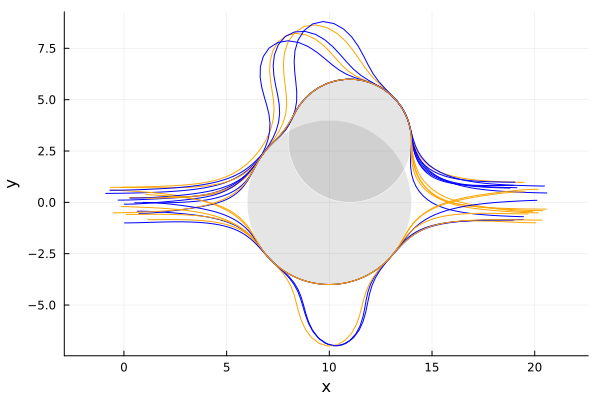

In [7]:
Plots.xlabel!("x")
Plots.ylabel!("y")

In [12]:
for i in 1:(size(full_traj)[2])
    println(maximum(full_traj[:,i]))
end

4.981744346955119
4.497335304543347
5.107956087338795
4.500533973965664
20.720952265849544
6.999996912442266
1.495786063204964
20.99851267096727
6.999995708622616
4.647400088975112


In [17]:
CSV.write("data/trajs_noise1.csv",  Tables.table(full_traj), writeheader=false)

"data/trajs_noise1.csv"

In [18]:
load_traj = Array(CSV.read("data/trajs_noise1.csv",DataFrame,header=false);)

100000×10 Matrix{Float64}:
 1.88085      -0.152252     1.90719      …  19.2379      0.186522  3.14159
 1.88153      -0.13575      1.9074          19.0471      0.186522  3.13248
 1.88237      -0.114835     1.90764         18.8564      0.18826   3.12414
 1.88314      -0.095576     1.90787         18.6657      0.19159   3.11673
 1.88377      -0.0806218    1.90806         18.4749      0.196333  3.11008
 1.8843       -0.0707825    1.90823      …  18.2842      0.202344  3.1039
 1.88475      -0.0659647    1.90839         18.0935      0.209535  3.09785
 1.88517      -0.0657054    1.90855         17.9029      0.217881  3.09159
 1.88561      -0.0694621    1.90872         17.7123      0.227421  3.08482
 1.88608      -0.0767596    1.90894         17.5217      0.238252  3.07725
 ⋮                                       ⋱                         
 1.2          -0.00917346   1.2              0.560265   -0.940136  3.14426
 1.05         -0.00924828   1.05             0.440265   -0.940456  3.14471
 0.9  

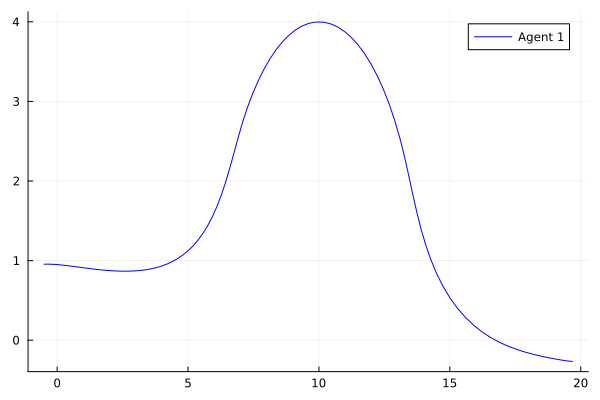

In [15]:
traj = load_traj[101:200, :]  # select rows 1 to 100, and all columns
Plots.plot(traj[:,5],traj[:,6],color="blue",label="Agent 1")
# Plots.plot(traj[:,4],traj[:,5],color="orange",label="Agent 2")